# Gene target analysis

Cell factory engineering strategies can be used to improve the production of progesterone in our modelled *S. cerevisiae* strain (iMM904_progesterone.xml).

We investigate if gene knockouts suggested in literature actually have an improving effect on the production of progesterone, and if it would be appropiate to incorporate these gene knockouts in our model. 

Using OptGene from cameo, we investigate if there are other potential gene knockout strategies that could be used to improve the production of progesterone.

Finally, we perform flux scanning based enforced objective flux (FSEOF) analysis to investigate reactions that are significantly up- or down-regulated as a result of an enhanced flux towards progesterone. This analysis reveals up- and downregulation targets. 

In [249]:
# Load libraries
from cobra.io import read_sbml_model
from cameo.strain_design import OptGene
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Knockout analysis

It has been suggested to knockout ERG5 and ERG6 in order to drive the flux towards the production of cholesterol instead of the natural produced steriod ergosterol (**Figure 5.1**) (Jiang, Yi-qi, and Jian-ping Lin 2022). It is from zymosterol, the knockouts should improve the flux towards cholesterol. It might improve the production of progesterone because cholesterol is an intermediate in the implemented heterologous pathway. However, it can be problematic to knockout ERG5 and ERG6 because ergosterol is an essential compound in the cellular membrane of *S. cerevisiae* (Jordá, Tania, and Sergi Puig 2020).

![figures/3_Fig1_Steriods_ERG5_ERG6.png](figures/3_Fig1_Steriods_ERG5_ERG6.png)
**Figure 5.1** (Jiang, Yi-qi, and Jian-ping Lin 2022)
**A**) Synthesis of steroids. Solid arrows represent reactions validated in yeast, and dashed arrows implicate conversions catalyzed by 
unknown enzyme(s). The endogenous ergosterol pathway in yeast is highlighted in blue. The three different sheds of blue represented three modules: mevalonate (MVA) biosynthesis, farnesyl pyrophosphate (FPP) biosynthesis and ergosterol biosynthesis. Heterologous synthesis of animal-derived steroids in yeast already or potentially is highlighted in orange. Heterologous synthesis of phytosterols already or potentially in yeast is highlighted in green. The reaction catalyzed by UV-light is highlighted in yellow and common steroids involved in biotransformation is highlighted in purple. The enzymes marked in red represent the ones that require NADPH/NADP+, and the ones that require ATP are marked in purple. 
**B**) The numbering of steroid’s carbon skeleton

We investigate the influence it has on the cell to knockout ERG5 and ERG6.

In [250]:
# Load model
infilename = 'models/iMM904_progesterone.xml'
print(f"Loading {infilename}")
model = read_sbml_model(infilename)

Loading models/iMM904_progesterone.xml


In [251]:
# Knockout ERG5 and ERG6
KOs = ["YMR015C","YML008C"]
model_ERG5_ERG6 = model.copy()
model_ERG5_ERG6.id = "iMM904_progesterone_ERG5_ERG6"
print(f"Model {model_ERG5_ERG6.id} were made as a copy of {model.id}")
print(f"For model {model_ERG5_ERG6.id}:")
for KO in KOs:
    model_ERG5_ERG6.genes.get_by_id(KO).knock_out()
    if model_ERG5_ERG6.genes.get_by_id(KO).functional == False:
        print(f"{model_ERG5_ERG6.genes.get_by_id(KO).name} were knocked out")

Model iMM904_progesterone_ERG5_ERG6 were made as a copy of iMM904_progesterone
For model iMM904_progesterone_ERG5_ERG6:
ERG5 were knocked out
ERG6 were knocked out


In [252]:
# max growth and max progesterone production
with model:
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.DM_progesterone_c
    baseline_max_production = model.optimize().objective_value
print(f"Maximum growth: µ = {baseline_max_growth}")
print(f"Maximum progesterone production: {baseline_max_production}")

Maximum growth: µ = 0.2878657037040168
Maximum progesterone production: 0.16666666666666666


Growth and progesterone production are both defined as objective below because the cell has to grow and produce progesterone (discussed in details in 03_maximum_theoretical_yield.ipynb). This reflects the reality.

In [253]:
# growth and progesterone production when both are set to objective
with model:
    print(f'For model: {model.id}')
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone_production = solution.fluxes['DM_progesterone_c']
    print(f"Growth in complete model: µ = {growth} mmol/gDW*h")
    print(f"Progesterone production in complete model: {progesterone_production} mmol/gDW*h")

For model: iMM904_progesterone
Growth in complete model: µ = 0.11872292252086923 mmol/gDW*h
Progesterone production in complete model: 0.15620047742340085 mmol/gDW*h


In [254]:
# ERG5 and ERG6 knockout influence on growth and progesterone production
with model_ERG5_ERG6:
    print(f'For model: {model_ERG5_ERG6.id}')
    model_ERG5_ERG6.objective = {model_ERG5_ERG6.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model_ERG5_ERG6.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model_ERG5_ERG6.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone_production = solution.fluxes['DM_progesterone_c']
    print(f"Growth when ERG5 and ERG6 knocked out: µ = {growth} mmol/gDW*h")
    print(f"Progesterone production when ERG5 and ERG6 knocked out: {progesterone_production} mmol/gDW*h")

For model: iMM904_progesterone_ERG5_ERG6
Growth when ERG5 and ERG6 knocked out: µ = 0.11872292252086744 mmol/gDW*h
Progesterone production when ERG5 and ERG6 knocked out: 0.15620047742340087 mmol/gDW*h


Surprisingly, knocking out ERG5 and ERG6 does not seem to influence the cell growth (µ = 0.119 mmol/gDW*h) or the progesterone productivity (0.156 mmol/gDW * h). We further investigate if this is actually the case or if there is a problem in the model to take into account.

Our strategy for investigating this:
1. Be sure that the knockout function work as intended
2. Confirm that knocking out ERG5 and ERG6 has an influence on some reactions
3. Go through the ergosterol pathway in the model and verify that is coherent (a summary table is provided)

In [255]:
#1 Reaction where progesterone is formed
for reac in model.metabolites.progesterone_c.reactions:
    print(reac)

DM_progesterone_c: progesterone_c --> 
R02216: nad_c + pregnenolone_c <=> h_c + nadh_c + progesterone_c


In [256]:
#1 The gene encoding the enzyme driving the reaction where progesterone is formed
for gene in model.reactions.R02216.genes:
    print(f"Gene involved in progesterone formation (R02216 reaction): {gene}")

Gene involved in progesterone formation (R02216 reaction): HSD3B


In [257]:
#1 Progesterone production when knocking out the gene encoding the enzyme driving the reaction
model_3betaHSD = model.copy()
model_3betaHSD.genes.HSD3B.knock_out()
model_3betaHSD.id = "iMM904_progesterone_3betaHSD"

with model as md:
    print(f'For model: {md.id}')
    md.objective = {md.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    md.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = md.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone_production = solution.fluxes['DM_progesterone_c']
    print(f"Growth: µ = {growth} mmol/gDW*h")
    print(f"Progesterone productivity: {progesterone_production} mmol/gDW*h")

with model_3betaHSD as md:
    print(f'For model: {md.id}')
    md.objective = {md.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    md.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = md.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone_production = solution.fluxes['DM_progesterone_c']
    print(f"Growth: µ = {growth} mmol/gDW*h")
    print(f"Progesterone productivity: {progesterone_production} mmol/gDW*h")


For model: iMM904_progesterone
Growth: µ = 0.11872292252086923 mmol/gDW*h
Progesterone productivity: 0.15620047742340085 mmol/gDW*h
For model: iMM904_progesterone_3betaHSD
Growth: µ = 0.28786570370678205 mmol/gDW*h
Progesterone productivity: -0.0 mmol/gDW*h


When 3beta-HSD is knocked out, there is as expected no production of progesterone. It is verified that the knockout function works as intended. 

In [258]:
#2 Investigate if the knockout of ERG5 and ERG6 influences some reactions (default objective function is growth)
fluxes = model.optimize().fluxes
fluxes_knockout = model_ERG5_ERG6.optimize().fluxes
count1 = 0
count2 = 0
for i, (flux, flux_knockout) in enumerate(zip(round(fluxes,3), round(fluxes_knockout,3))):
    if flux != flux_knockout:
        count1 = count1+1
        if flux-flux_knockout > 4 or flux-flux_knockout < -4:
            print(f'Reaction {fluxes.index[i]}: flux: {flux} is very different from knockout_ERG5_ERG6 flux: {flux_knockout}')
            print(model.reactions.get_by_id(fluxes.index[i]))
            count2 = count2 + 1

print('\nKnocking out ERG5 and ERG6 influence the flux of', count1, 'reactions')
print('Knocking out ERG5 and ERG6 has a high influence the flux of', count2, 'reactions')

Reaction GLUK: flux: 0.0 is very different from knockout_ERG5_ERG6 flux: 10.0
GLUK: atp_c + glc__D_c --> adp_c + g6p_B_c + h_c
Reaction G6PI3: flux: 0.0 is very different from knockout_ERG5_ERG6 flux: 10.0
G6PI3: g6p_B_c <=> f6p_c
Reaction FBA: flux: 8.925 is very different from knockout_ERG5_ERG6 flux: 0.0
FBA: fdp_c <=> dhap_c + g3p_c
Reaction FBA3: flux: 0.0 is very different from knockout_ERG5_ERG6 flux: 8.925
FBA3: s17bp_c <=> dhap_c + e4p_c
Reaction HEX1: flux: 10.0 is very different from knockout_ERG5_ERG6 flux: 0.0
HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c
Reaction PFK: flux: 8.925 is very different from knockout_ERG5_ERG6 flux: 0.0
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c
Reaction PFK_3: flux: 0.0 is very different from knockout_ERG5_ERG6 flux: 8.925
PFK_3: atp_c + s7p_c --> adp_c + h_c + s17bp_c
Reaction PGI: flux: 8.707 is very different from knockout_ERG5_ERG6 flux: -1.293
PGI: g6p_c <=> f6p_c
Reaction TALA: flux: 0.263 is very different from knockout_ERG5_ERG6 flux:

Looking at the 9 reactions with highest flux difference, it is mainly reactions influencing the glycolysis. 

The ergosterol pathway in the model starting from zymosterol is investigated by checking each reaction and the gene encoding the enzyme catalyzing the given reaction (**Figure 5.1** in comparison to our model). One example is shown below, and a summary is seen in **Table 5.1**.

In [259]:
#3 reactions where zymosterol participate
# SAM24MT is the reaction where zymosterol is converted to fecosterol
for reac in model.metabolites.zymst_c.reactions:
    print(reac)

C3STKR2: h_c + nadph_c + zym_int2_c --> nadp_c + zymst_c
ZYMSTt: zymst_e <=> zymst_c
SAM24MT: amet_c + zymst_c --> ahcys_c + fecost_c + h_c
ZYMSTAT_SC: 0.655 hdcoa_c + 0.01 hexccoa_c + 0.27 odecoa_c + 0.02 pmtcoa_c + 0.03 stcoa_c + 0.015 tdcoa_c + 0.01 zymst_c --> coa_c + 0.01 zymstest_SC_c
CHLSTI: amet_c + o2_c + zymst_c --> ahcys_c + ergtetrol_c + 2.0 h2o_c + h_c
ZYMSTESTH_SC: h2o_c + 0.01 zymstest_SC_c --> h_c + 0.02 hdca_c + 0.655 hdcea_c + 0.01 hexc_c + 0.03 ocdca_c + 0.27 ocdcea_c + 0.015 ttdca_c + 0.01 zymst_c
R04804: zymst_c --> cholesta724dien3betaol_c
BIOMASS_SC5_notrace: 1.1348 13BDglcn_c + 0.4588 ala__L_c + 0.046 amp_c + 0.1607 arg__L_c + 0.1017 asn__L_c + 0.2975 asp__L_c + 59.276 atp_c + 0.0447 cmp_c + 0.0066 cys__L_c + 0.0036 damp_c + 0.0024 dcmp_c + 0.0024 dgmp_c + 0.0036 dtmp_c + 0.0007 ergst_c + 0.1054 gln__L_c + 0.3018 glu__L_c + 0.2904 gly_c + 0.5185 glycogen_c + 0.046 gmp_c + 59.276 h2o_c + 0.0663 his__L_c + 0.1927 ile__L_c + 0.2964 leu__L_c + 0.2862 lys__L_c + 0.80

In [260]:
#3 reactions where ERG6 participate
model.genes.YML008C

Gene identifier,YML008C
Name,ERG6
Memory address,0x07f3daea056d0
Functional,True
In 1 reaction(s),SAM24MT


**Table 1**: Overview of ergosterol pathway in the model. Yellow background indicated that the reaction occurs in the cytoplasm and blue background indicated that the reaction happens in the ER.
![figures/3_Fig1_Steriods_ERG5_ERG6.png](figures/Table1_ERG_pathway.png)

All reactions in the ergosterol pathway (**Figure 5.1**) are present in the model. Next is to investigate the flux of the reactions.

In [261]:
# flux through ergosterol pathway when ERG5 and ERG6 are knocked out
erg_pathway = ['SAM24MT', 'C8STI', 'C5STDS', 'C22STDS', 'ERGTETROLter', 'C24STRer', 'ERGSTter']
with model_ERG5_ERG6:
    for reac in erg_pathway:
        model_ERG5_ERG6.objective = model_ERG5_ERG6.reactions.get_by_id(reac)
        print('When ERG5 and ERG6 are knocked out', reac, 'flux is', round(model_ERG5_ERG6.optimize().objective_value,3))

When ERG5 and ERG6 are knocked out SAM24MT flux is 0.0
When ERG5 and ERG6 are knocked out C8STI flux is 0.0
When ERG5 and ERG6 are knocked out C5STDS flux is 0.0
When ERG5 and ERG6 are knocked out C22STDS flux is 0.0
When ERG5 and ERG6 are knocked out ERGTETROLter flux is 0.182
When ERG5 and ERG6 are knocked out C24STRer flux is 0.182
When ERG5 and ERG6 are knocked out ERGSTter flux is 0.182


Flux suddenly appear in the reaction where ergosta-5,7,22,24(28)-tetraen-3b-ol diffuses from the cytoplasm into the ER. The most obvious reason would be that there is another reaction which produces ergosta-5,7,22,24(28)-tetraen-3b-ol in the cytoplasm. 

In [262]:
# what reactions does ergosta-5,7,22,24(28)-tetraen-3b-ol participate in
model.metabolites.ergtetrol_c

Metabolite identifier,ergtetrol_c
Name,Ergosta 5 7 22 24 28 tetraen 3beta ol C28H42O
Memory address,0x07f3daed974f0
Formula,C28H42O
Compartment,c
In 4 reaction(s),"ERGTETROLter, CHLSTI, C22STDSx, C22STDS"


In [263]:
# reaction is not a part of the ergosterol pathway
model.reactions.CHLSTI

Reaction identifier,CHLSTI
Name,Cholestenol delta isomerase lumped reaction
Memory address,0x07f3dae780eb0
Stoichiometry,amet_c + o2_c + zymst_c --> ahcys_c + ergtetrol_c + 2.0 h2o_c + h_c S-Adenosyl-L-methionine + O2 O2 + Zymosterol C27H44O --> S-Adenosyl-L-homocysteine + Ergosta 5 7 22 24 28 tetraen 3beta ol C28H42O + 2.0 H2O H2O + H+
GPR,EBP
Lower bound,0.0
Upper bound,999999.0


Zymosterol is used in the above reaction for the production of ergosta-5,7,22,24(28)-tetraen-3b-ol. This is likely a reason why it does not make any change in progesterone production to knockout ERG5 and ERG6. Therefore, we try to knockout EBP on top of ERG5 and ERG6. 

In [264]:
# knock out EBP
KOs = ["EBP"]
model_ERG5_ERG6_EBP = model_ERG5_ERG6.copy()
model_ERG5_ERG6_EBP.id = "iMM904_progesterone_ERG5_ERG6_EBP"
print(f"Model {model_ERG5_ERG6_EBP.id} were made as a copy of {model_ERG5_ERG6.id}")
print(f"For model {model_ERG5_ERG6_EBP.id}:")
for KO in KOs:
    model_ERG5_ERG6_EBP.genes.get_by_id(KO).knock_out()
    if model_ERG5_ERG6_EBP.genes.get_by_id(KO).functional == False:
        print(f"{model_ERG5_ERG6_EBP.genes.get_by_id(KO)} was knocked out")

Model iMM904_progesterone_ERG5_ERG6_EBP were made as a copy of iMM904_progesterone_ERG5_ERG6
For model iMM904_progesterone_ERG5_ERG6_EBP:
EBP was knocked out


In [265]:
# flux through ergosterol pathway when ERG5, ERG6, and EBP are knocked out
erg_pathway = ['SAM24MT', 'C8STI', 'C5STDS', 'C22STDS', 'ERGTETROLter', 'C24STRer', 'ERGSTter']
with model_ERG5_ERG6_EBP:
    for reac in erg_pathway:
        model_ERG5_ERG6_EBP.objective = model_ERG5_ERG6_EBP.reactions.get_by_id(reac)
        print('When ERG5, ERG6, and EBP are knocked out', reac, 'flux is', round(model_ERG5_ERG6_EBP.optimize().objective_value,3))

When ERG5, ERG6, and EBP are knocked out SAM24MT flux is 0.0
When ERG5, ERG6, and EBP are knocked out C8STI flux is 0.0
When ERG5, ERG6, and EBP are knocked out C5STDS flux is 0.0
When ERG5, ERG6, and EBP are knocked out C22STDS flux is 0.0
When ERG5, ERG6, and EBP are knocked out ERGTETROLter flux is 0.0
When ERG5, ERG6, and EBP are knocked out C24STRer flux is 0.0
When ERG5, ERG6, and EBP are knocked out ERGSTter flux is 0.0


In [266]:
# Progesterone productivity and growth
for m in (model,model_ERG5_ERG6,model_ERG5_ERG6_EBP):
    with m as md:
        print(f'For model: {md.id}')
        md.objective = {md.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                        md.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
        solution = md.optimize()
        growth = solution.fluxes['BIOMASS_SC5_notrace']
        progesterone_production = solution.fluxes['DM_progesterone_c']
        print(f"Growth: µ = {round(growth,3)}")
        print(f"Progesterone productivity: {round(progesterone_production,3)} mmol/gDW*h")

For model: iMM904_progesterone
Growth: µ = 0.119
Progesterone productivity: 0.156 mmol/gDW*h
For model: iMM904_progesterone_ERG5_ERG6
Growth: µ = 0.119
Progesterone productivity: 0.156 mmol/gDW*h
For model: iMM904_progesterone_ERG5_ERG6_EBP
Growth: µ = 0.0
Progesterone productivity: 0.167 mmol/gDW*h


It is observed that knocking out ERG5, ERG6, and EBP make the cell unable to grow recalling that ergosterol is an important compound in the cellular membrane of *S. cerevisiae* (Jordá, Tania, and Sergi Puig 2020).

We investigate if knocking out other genes would improve the production of progesterone using OptGene from Cameo.

In [267]:
# Run optGene algorithm
optgene = OptGene(model)
result = optgene.run(target=model.reactions.R02216,
                   biomass=model.reactions.BIOMASS_SC5_notrace, 
                   substrate=model.metabolites.glc__D_e, 
                   max_evalutations=50000, plot=False)

In [268]:
# Printing result
result

The cell engineering strategy of knocking out genes does not improve the production of progesterone. It can have adverse effects on the cell to knockout genes because there is a chance that it results in significant lowered fitness properties.

### Up-regulation and down-regulation targets

We use FSEOF analysis to find targets that are up- or down-regulated as a result of an increasing flux towards the production of progesterone at the same time of maximizing biomass formation flux (Choi, Hyung Seok, et al. 2010).

In [269]:
# Run FSEOF analysis
fseof = FSEOF(model)
result = fseof.run(target=model.reactions.get_by_id('DM_progesterone_c'))
tmp_df = result.data_frame
print("Fluxes that changes in the FSEOF analysis:")
tmp_df

Fluxes that changes in the FSEOF analysis:


,1,2,3,4,5,6,7,8,9,10
ACALDtm,-0.065708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.112235,-0.291209,0.000000
ACONT,0.172616,0.268184,0.251115,0.234046,0.216977,0.199908,0.182305,0.164362,0.146420,0.128478
ACtm,-0.065708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ALCD2irm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112235,0.291209,0.000000
ALCD2x_copy2,-15.765364,-15.741465,-15.758708,-15.775951,-15.793193,-15.810436,-15.843577,-15.426625,-14.672647,-14.388852
...,...,...,...,...,...,...,...,...,...,...
R02216,0.015000,0.030000,0.045000,0.060000,0.075000,0.090000,0.105000,0.120000,0.135000,0.150000
R03353,0.015000,0.030000,0.045000,0.060000,0.075000,0.090000,0.105000,0.120000,0.135000,0.150000
R07215,0.015000,0.030000,0.045000,0.060000,0.075000,0.090000,0.105000,0.120000,0.135000,0.150000
MNXR4011,0.015000,0.030000,0.045000,0.060000,0.075000,0.090000,0.105000,0.120000,0.135000,0.150000


In [270]:
# Remove reactions 
HP = ('R07498', 'R05703', 'R01456', 'R02216', 'R03353', 'R07215', 'R04804', 'MNXR4011', 'ECYP11A1', '4-methylpentanal sink')
df = tmp_df.copy()

print("Removing reactions that are part of the introduced heterologous pathway except DM_progesterone_c for reference")
print("Removing reactions with a flux in between -1 and 1 both at low and high progesterone productivity")
for i, reac in enumerate(tmp_df.index):
    if reac != "DM_progesterone_c" and (reac in HP or ((tmp_df.values[i,0] < 1 and tmp_df.values[i,0] > -1) and (tmp_df.values[i,9] < 1 and tmp_df.values[i,9] > -1))):
        df = df.drop(reac)
df

Removing reactions that are part of the introduced heterologous pathway except DM_progesterone_c for reference
Removing reactions with a flux in between -1 and 1 both at low and high progesterone productivity


,1,2,3,4,5,6,7,8,9,10
ALCD2x_copy2,-15.765364,-15.741465,-15.758708,-15.775951,-15.793193,-15.810436,-15.843577,-15.426625,-14.672647,-14.388852
CO2t,-18.105444,-18.214483,-18.362260,-18.510036,-18.657812,-18.805588,-18.997352,-18.695089,-17.987397,-17.279705
CO2tm,-1.343381,-1.489176,-1.698765,-1.908354,-2.117942,-2.327531,-2.535228,-2.741726,-2.948225,-3.154723
DHAK,0.000000,0.138013,0.889208,1.640403,2.391598,3.142794,3.718548,4.067152,4.325661,4.584169
ENO,17.864887,17.948196,18.129357,18.310518,18.491680,18.672841,18.866579,19.010299,19.108971,19.207642
ETOHt,-15.765364,-15.741465,-15.758708,-15.775951,-15.793193,-15.810436,-15.843577,-15.538860,-14.963856,-14.388852
GLUK,8.480239,8.493720,8.741302,8.988884,9.236466,9.484048,9.589316,9.604401,9.619486,9.634571
G3PT,0.000000,0.138013,0.889208,1.640403,2.391598,3.142794,3.718548,4.067152,4.325661,4.584169
G6PDH2r,1.032206,1.026594,0.792633,0.558672,0.324711,0.090750,0.000000,0.000000,0.000000,0.000000
G6PI3,8.480239,8.493720,8.741302,8.988884,9.236466,9.484048,9.589316,9.604401,9.619486,9.634571


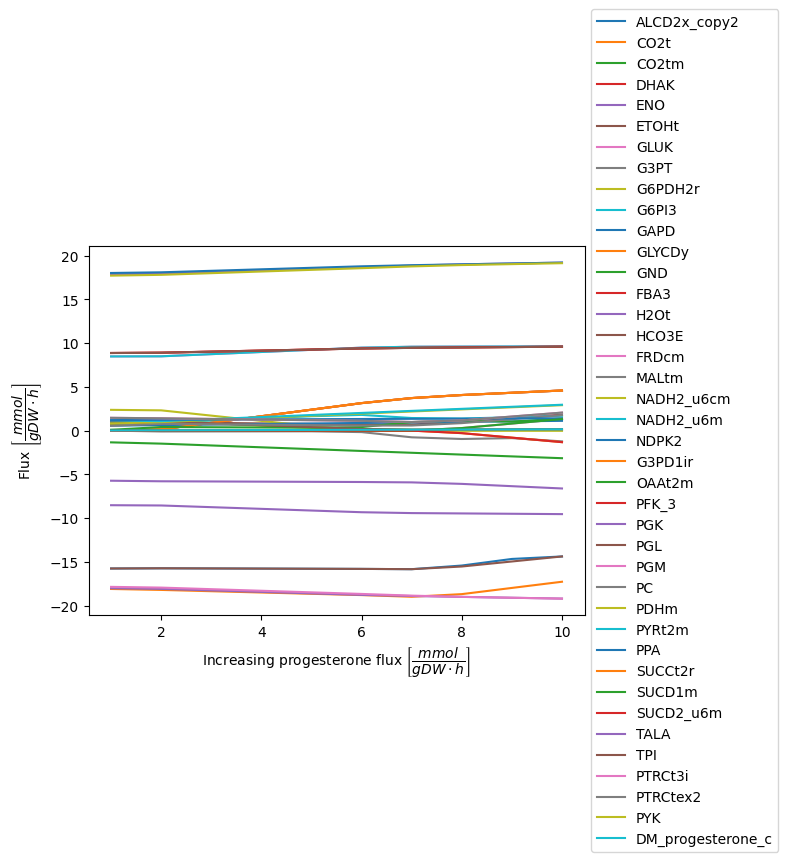

In [271]:
# plot FSEOF analysis
df.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r"Increasing progesterone flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");
plt.show()

As seen above, all reactions found from the FSEOF analysis are difficult to visualize together. Therefore, we select the reactions with the highest relative flux and visualize them.

In [272]:
# relative progesterone flux change
for i, reac in enumerate(df.index):
    if reac == 'DM_progesterone_c':
        prog_flux_change = df.iloc[i, 9]-df.iloc[i, 0]
        prog_flux_step_change = df.iloc[i, 1]-df.iloc[i, 0]
        prog_flux_change_percent = (prog_flux_change/df.iloc[i, 0])*100
        prog_flux_step_change_percent = (prog_flux_step_change/df.iloc[i, 0])*100

print(f"Progesterone flux change: {round(prog_flux_change,3)} mmol/(gDW*h) with steps of {round(prog_flux_step_change,3)} mmol/(gDW*h)")
print(f"Progesterone flux change: {prog_flux_change_percent}% with steps of {prog_flux_step_change_percent}%")

Progesterone flux change: 0.135 mmol/(gDW*h) with steps of 0.015 mmol/(gDW*h)
Progesterone flux change: 900.0% with steps of 100.0%


In [273]:
# reactions with highest relative flux change
df[1] = df[1].replace([0.000000], 0.000001)
df[10] = df[10].replace([0.000000], 0.000001)
df['relative_flux_change_percent'] = round(((df[10]-df[1])/df[1])*100, 0)
df = df.reindex(df.relative_flux_change_percent.abs().sort_values(ascending=False).index)
target_reactions_df = df.head(20)
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_flux_change_percent
GLYCDy,0.000001,0.138013,0.889208,1.640403,2.391598,3.142794,3.718548,4.067152,4.325661,4.584169,458416800.0
DHAK,0.000001,0.138013,0.889208,1.640403,2.391598,3.142794,3.718548,4.067152,4.325661,4.584169,458416800.0
G3PT,0.000001,0.138013,0.889208,1.640403,2.391598,3.142794,3.718548,4.067152,4.325661,4.584169,458416800.0
SUCD2_u6m,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.289945,-0.805128,-1.320311,-132031200.0
SUCCt2r,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.289945,-0.805128,-1.320311,-132031200.0
FRDcm,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.289945,0.805128,1.320311,132031000.0
MALtm,0.000001,-0.099743,-0.093394,-0.087046,-0.080698,-0.170362,-0.765990,-0.958776,-0.859584,-1.230576,-123057700.0
G3PD1ir,0.006833,0.144514,0.895296,1.646077,2.396859,3.147640,3.722968,4.071137,4.329210,4.587284,67034.0
SUCD1m,0.082421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.289945,0.805128,1.320311,1502.0
OAAt2m,0.089020,0.410018,0.383922,0.357826,0.331730,0.401646,0.976907,1.148935,1.028985,1.379219,1449.0


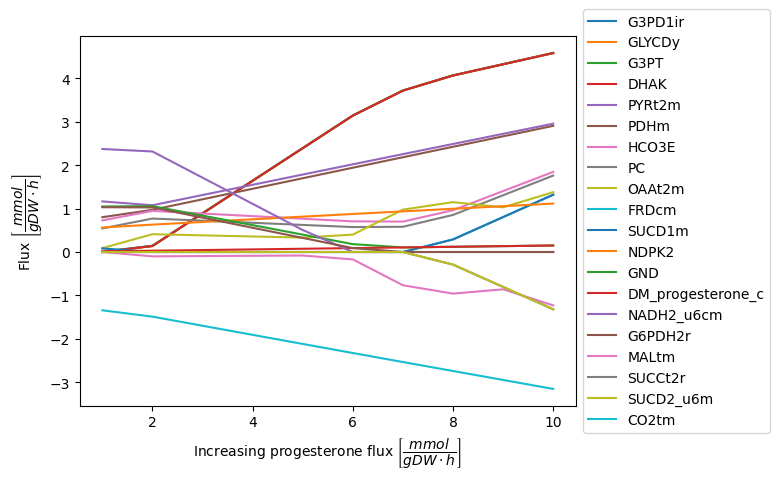

In [274]:
# plot of reactions with highest relative flux change
target_reactions_df_plot = target_reactions_df.iloc[:,:10]
target_reactions_df_plot = target_reactions_df_plot.reindex(target_reactions_df_plot[10].sort_values(ascending=False).index)
target_reactions_df_plot.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r"Increasing progesterone flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");
plt.show()

The legend on the figure above are sorted such that the reaction with the highest flux at a high progesterone flux are in the top of the list. We see that the reactions G3PD1ir, GLYCDy, G3PT, and DHAK all are upregulated the same when progesterone is upregulated (all four graphs lie on top of each other). These four reactions are the one that are mostly upregulated and are therefore of special interest.

In [275]:
# printing reations that are either up- or down-regulated
for i in range(20):
    print(f"{model.reactions.get_by_id(target_reactions_df.index.values[i]).name}, {model.reactions.get_by_id(target_reactions_df.index[i])}")

Glycerol dehydrogenase  NADP dependent , GLYCDy: glyc_c + nadp_c --> dha_c + h_c + nadph_c
Dihydroxyacetone kinase, DHAK: atp_c + dha_c --> adp_c + dhap_c + h_c
Glycerol-3-phosphatase, G3PT: glyc3p_c + h2o_c --> glyc_c + pi_c
Succinate dehydrogenase  ubiquinone 6   mitochondrial, SUCD2_u6m: q6_m + succ_m <=> fum_m + q6h2_m
Succinate transport via proton symport, SUCCt2r: h_e + succ_e <=> h_c + succ_c
Fumarate reductase  cytosolicmitochondrial, FRDcm: fadh2_m + fum_c --> fad_m + succ_c
Malate transport  mitochondrial, MALtm: mal__L_c + pi_m <=> mal__L_m + pi_c
Glycerol 3 phosphate dehydrogenase  NAD , G3PD1ir: dhap_c + h_c + nadh_c --> glyc3p_c + nad_c
Succinate dehydrogenase, SUCD1m: fad_m + succ_m <=> fadh2_m + fum_m
Oxaloacetate transport  mitochondrial, OAAt2m: h_c + oaa_c <=> h_m + oaa_m
progesterone demand, DM_progesterone_c: progesterone_c --> 
Pyruvate dehydrogenase, PDHm: coa_m + nad_m + pyr_m --> accoa_m + co2_m + nadh_m
Pyruvate carboxylase, PC: atp_c + hco3_c + pyr_c --> adp

The reactions that have the highest relative flux change when increasing the flux towards progesterone (progesterone demand) are shown above. They are promising up- or downregulation targets (relative_flux_change percent) for increasing progesterone production.

In the following, we will focus on G3PD1ir, GLYCDy, G3PT, and DHAK, since they are mostly upregulated:

In [276]:
# Reactions of mostly upregulated reactions
up_reacs = ["G3PD1ir", "DHAK", "G3PT", "GLYCDy"]
for reac in up_reacs:
    print(model.reactions.get_by_id(reac))

G3PD1ir: dhap_c + h_c + nadh_c --> glyc3p_c + nad_c
DHAK: atp_c + dha_c --> adp_c + dhap_c + h_c
G3PT: glyc3p_c + h2o_c --> glyc_c + pi_c
GLYCDy: glyc_c + nadp_c --> dha_c + h_c + nadph_c


It is clear that these four reactions form a cycle, where NAD(+) and NADPH are formed. Thereby, by increasing the flux through this cycle, the concentration of NAD(+) and NADPH are increased in the cell. Since these co-factors are used to produce progesterone it makes sense that when these co-factors are increased then the flux through progesterone is increased as well.

We invistigate the optimal fluxes of the reactions:

In [277]:
# optimial flux of upregulated reactions
with model:
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth}
    model.optimize()
    for reac in up_reacs:
        print(f"Optimial flux of {model.reactions.get_by_id(reac).id}: {round(model.reactions.get_by_id(reac).flux,4)} mmol/(gDW*h)")

Optimial flux of G3PD1ir: 4.6933 mmol/(gDW*h)
Optimial flux of DHAK: 4.6903 mmol/(gDW*h)
Optimial flux of G3PT: 4.6903 mmol/(gDW*h)
Optimial flux of GLYCDy: 4.6903 mmol/(gDW*h)


We see that the optimal fluxes through the reactions are exactly the same for three of the reactions. Only the reaction G3PDir has a slightly higher flux. This means that the majority of flux through G3PDir and all the flux through the three other reactions are used for NAD(+)/NADPH producing cycling. To test whether this increased NAD(+)/NADPH producing cycling, increases the performance of the model, we remove the possibility for the model to make the NAD(+)/NADPH producing cycling by removing the G3PT reaction from the model. The result is visualized in a phase plane.

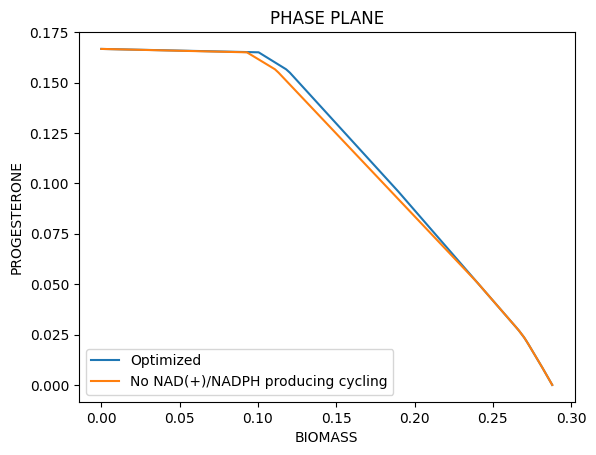

In [278]:
# Phase plane of 
legends = ["Optimized","No NAD(+)/NADPH producing cycling"]
for legend in legends:
    with model as m:
        if legend == "No NAD(+)/NADPH producing cycling":
            m.reactions.G3PT.upper_bound = 0
        m.objective = m.reactions.DM_progesterone_c
        m.optimize()
        max_prog = m.reactions.DM_progesterone_c.flux
        m.objective = m.reactions.BIOMASS_SC5_notrace
        len = 100
        pp = []
        biomass = []
        for i in range(len):
            pp.append((i/(len-1))*max_prog)
            m.reactions.DM_progesterone_c.lower_bound = pp[i]
            biomass.append(m.optimize().objective_value)
        plt.plot(biomass,pp)
plt.legend(legends)
plt.xlabel("BIOMASS")
plt.ylabel("PROGESTERONE")
plt.title("PHASE PLANE")
plt.show()

We see that the optimized model has a better performance than the model with no NAD(+)/NADPH producing cycling of the reactions: G3PD1ir, GLYCDy, G3PT, and DHAK. This prove that an upregulation of these reactions would be beneficial. In order to get a quantitative number for how much NAD(+)/NADPH producing cycling of the four reactions theoretically can improve the progesterone productivity, we keep the growth rate constant.

In [280]:
with model:
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth}
    model.optimize()
    optimized_bio = model.reactions.BIOMASS_SC5_notrace.flux
    model.reactions.BIOMASS_SC5_notrace.lower_bound = optimized_bio
    model.reactions.BIOMASS_SC5_notrace.upper_bound = optimized_bio
    model.objective = model.reactions.DM_progesterone_c
    pp = []
    for i, legend in enumerate(legends):
        if legend == "No NAD(+)/NADPH producing cycling":
            model.reactions.G3PT.upper_bound = 0
        model.optimize()
        pp.append(model.reactions.DM_progesterone_c.flux)
        print(f"{legend} model at growth: {round(optimized_bio,4)} gDW/h | Maximum progesterone productivity: {round(pp[i],4)} mmol/(gDW*h)")
print(f"Procentage increase in maximum progesterone productivity {round(((pp[0]/pp[1])-1)*100,2)}%")

Optimized model at growth: 0.1187 gDW/h | Maximum progesterone productivity: 0.1562 mmol/(gDW*h)
No NAD(+)/NADPH producing cycling model at growth: 0.1187 gDW/h | Maximum progesterone productivity: 0.1503 mmol/(gDW*h)
Procentage increase in maximum progesterone productivity 3.91%


### References
Choi, Hyung Seok, et al. "In silico identification of gene amplification targets for improvement of lycopene production." Applied and environmental microbiology 76.10 (2010): 3097-3105.

Jiang, Yi-qi, and Jian-ping Lin. "Recent progress in strategies for steroid production in yeasts." World Journal of Microbiology and Biotechnology 38.6 (2022): 1-14.

Jordá, Tania, and Sergi Puig. "Regulation of ergosterol biosynthesis in Saccharomyces cerevisiae." Genes 11.7 (2020): 795.